In [163]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import hcp_utils as hcp


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

pd.options.mode.chained_assignment = None  # Hide long warnings

import shap

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.preprocessing import LabelEncoder

In [2]:
file_path = "parcellations"
file_list = os.listdir(file_path)
mmp = [] # Glasser 2016 which partitions each hemisphere into 180 regions
ca = [] # Cole-Anticevic 2019 which further partitions each hemisphere into ~350 regions
for i in file_list:
    if "mmp" in i:
        mmp_file = np.load(file_path + "/" + i)
        if mmp_file.shape == (3600, 379):
            mmp.append(np.load(file_path + "/" + i))

In [3]:
np.load("parcellations/sub-193845_task-rest_parcellation-ca_timeseries.npy").shape

(3600, 718)

In [4]:
open_access_data = pd.read_csv("Behavioral Data/Behavioral_Data.csv")
restricted_data = pd.read_csv("Behavioral Data/RESTRICTED_BEHAVIORAL_DATA.csv")
subject_data = open_access_data.merge(restricted_data, how = 'inner', on = 'Subject')

file_path = "parcellations"
file_list = os.listdir(file_path)
mmp = {}
ca = {}
for filename in file_list:
    subject_id = filename[4:10]

    if subject_id.isdigit():
        subject_id = int(subject_id)

        if "mmp" in filename:
            mmp_file = np.load(file_path + "/" + filename)
            if mmp_file.shape == (3600, 379):
                mmp[subject_id] = mmp_file
        if "ca" in filename:
            ca_file = np.load(file_path + "/" + filename)
            if ca_file.shape == (3600, 718):
                ca[subject_id] = ca_file

mmp_data = pd.DataFrame({
    'Subject': list(mmp.keys()),
    'Brain_Data': list(mmp.values())  # (3600, 379) arrays
})


mmp_data = subject_data.merge(mmp_data, on='Subject', how='inner')

ca_data = pd.DataFrame({
    'Subject': list(ca.keys()),
    'Brain_Data': list(ca.values())  # (3600, 718) arrays
})


ca_data = subject_data.merge(ca_data, on='Subject', how='inner')

In [85]:
mmp_data.head()

Subject Release Acquisition Gender    Age  3T_Full_MR_Compl  T1_Count  \
0   100610    S900         Q08      M  26-30              True         2   
1   102311    S500         Q06      F  26-30              True         1   
2   102816      Q3         Q03      F  26-30              True         1   
3   104416    S900         Q09      F  31-35              True         2   
4   105923    MEG2         Q07      F  31-35              True         2   

   T2_Count  3T_RS-fMRI_Count  3T_RS-fMRI_PctCompl  ...  \
0         1                 4                100.0  ...   
1         1                 4                100.0  ...   
2         1                 4                100.0  ...   
3         2                 4                100.0  ...   
4         2                 4                100.0  ...   

   SSAGA_Times_Used_Opiates  SSAGA_Times_Used_Sedatives  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   SSAGA_Times_Used_Stimulants  SSAGA_Mj_Use  SSAGA_Mj_Ab_Dep  \
0                          0.0           0.0              0.0   
1                          0.0           0.0              0.0   
2                          0.0           1.0              0.0   
3                          0.0           1.0              0.0   
4                          0.0           1.0              0.0   

   SSAGA_Mj_Age_1st_Use  SSAGA_Mj_Times_Used  \
0                   NaN                  0.0   
1                   NaN                  0.0   
2                   2.0                  3.0   
3                   4.0                  3.0   
4                   4.0                  1.0   

                                          Brain_Data  Handedness_Cat  \
0  [[2.3968613, 0.33524948, -0.15465337, 1.955118...               1   
1  [[-0.13254918, 0.16243707, 0.300286, 0.6371644...               1   
2  [[0.19969857, -0.7308231, -0.46953073, 0.19398...               1   
3  [[-0.58722323, -2.054348, -2.3991566, -0.60077...               1   
4  [[0.4015313, -0.47590375, -0.058990948, -0.747...               1   

                                  correlation_matrix  
0  [[1.0, 0.46619928616491757, 0.5387587799680043...  
1  [[1.0, 0.4145113094959292, 0.342818966658749, ...  
2  [[0.9999999999999998, 0.2989986241314227, 0.52...  
3  [[0.9999999999999998, 0.5081583697070787, 0.59...  
4  [[1.0, 0.5963831451011642, 0.6588621195832001,...  

[5 rows x 785 columns]

In [86]:
ca_data.head()

Subject Release Acquisition Gender    Age  3T_Full_MR_Compl  T1_Count  \
0   100610    S900         Q08      M  26-30              True         2   
1   102311    S500         Q06      F  26-30              True         1   
2   102816      Q3         Q03      F  26-30              True         1   
3   104416    S900         Q09      F  31-35              True         2   
4   105923    MEG2         Q07      F  31-35              True         2   

   T2_Count  3T_RS-fMRI_Count  3T_RS-fMRI_PctCompl  ...  \
0         1                 4                100.0  ...   
1         1                 4                100.0  ...   
2         1                 4                100.0  ...   
3         2                 4                100.0  ...   
4         2                 4                100.0  ...   

   SSAGA_Times_Used_Hallucinogens  SSAGA_Times_Used_Opiates  \
0                             0.0                       0.0   
1                             0.0                       0.0   
2                             0.0                       0.0   
3                             0.0                       0.0   
4                             0.0                       0.0   

   SSAGA_Times_Used_Sedatives  SSAGA_Times_Used_Stimulants  SSAGA_Mj_Use  \
0                         0.0                          0.0           0.0   
1                         0.0                          0.0           0.0   
2                         0.0                          0.0           1.0   
3                         0.0                          0.0           1.0   
4                         0.0                          0.0           1.0   

   SSAGA_Mj_Ab_Dep  SSAGA_Mj_Age_1st_Use  SSAGA_Mj_Times_Used  \
0              0.0                   NaN                  0.0   
1              0.0                   NaN                  0.0   
2              0.0                   2.0                  3.0   
3              0.0                   4.0                  3.0   
4              0.0                   4.0                  1.0   

                                          Brain_Data  \
0  [[2.3968613, 0.33524948, -0.15465337, 1.955118...   
1  [[-0.13254918, 0.16243707, 0.300286, 0.6371644...   
2  [[0.19969857, -0.7308231, -0.46953073, 0.19398...   
3  [[-0.58722323, -2.054348, -2.3991566, -0.60077...   
4  [[0.4015313, -0.47590375, -0.058990948, -0.747...   

                                  correlation_matrix  
0  [[1.0, 0.46619928616491757, 0.5387587799680043...  
1  [[1.0, 0.4145113094959292, 0.342818966658749, ...  
2  [[0.9999999999999998, 0.2989986241314227, 0.52...  
3  [[0.9999999999999998, 0.5081583697070787, 0.59...  
4  [[1.0, 0.5963831451011642, 0.6588621195832001,...  

[5 rows x 784 columns]

In [9]:
mmp_data["Handedness_Cat"] = mmp_data["Handedness"].apply(lambda x: 0 if x < 0 else 1)

In [87]:
hand_data = mmp_data[["Subject", "Gender", "Race", "Handedness", "Handedness_Cat"]]
hand_data

Subject Gender                                  Race  Handedness  \
0     100610      M                                 White          85   
1     102311      F                                 White          10   
2     102816      F                  Black or African Am.         100   
3     104416      F  Asian/Nat. Hawaiian/Othr Pacific Is.          65   
4     105923      F                                 White          35   
..       ...    ...                                   ...         ...   
167   943862      M                                 White          95   
168   958976      M                                 White          85   
169   966975      M                                 White          40   
170   971160      M                                 White          80   
171   995174      M                                 White         100   

     Handedness_Cat  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
167               1  
168               1  
169               1  
170               1  
171               1  

[172 rows x 5 columns]

In [13]:
left_handed = hand_data[hand_data['Handedness'] < 0]
right_handed = hand_data[hand_data['Handedness'] > 0]

# Handedness statistics
pd.DataFrame([
    left_handed.describe()['Handedness'], 
    right_handed.describe()['Handedness'], 
    hand_data['Handedness'].describe()
], index=['Left-Handed', 'Right-Handed', 'Overall']).T

Left-Handed  Right-Handed     Overall
count    13.000000    159.000000  172.000000
mean    -48.846154     79.622642   69.912791
std      34.104853     19.980585   40.129446
min    -100.000000     10.000000 -100.000000
25%     -75.000000     70.000000   65.000000
50%     -40.000000     85.000000   80.000000
75%     -30.000000     95.000000   95.000000
max      -5.000000    100.000000  100.000000

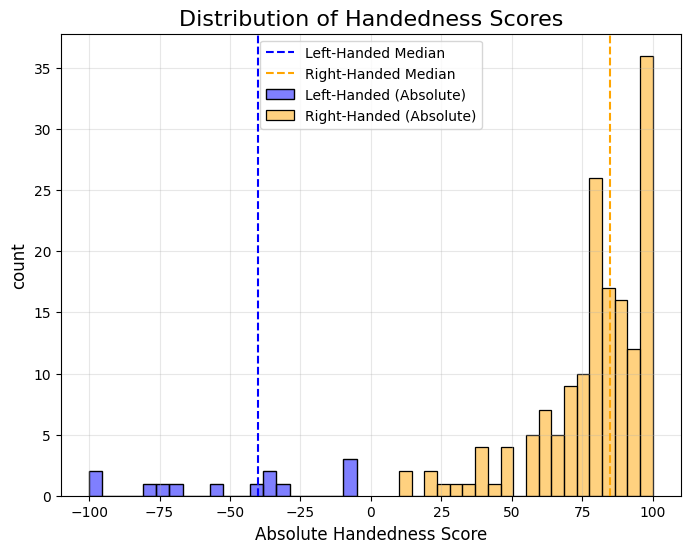

In [14]:
# Take absolute values of Handedness
left_handed_abs = left_handed['Handedness'].abs()
right_handed_abs = right_handed['Handedness'].abs()

plt.figure(figsize=(8, 6))
sns.histplot(left_handed['Handedness'], color='blue', label='Left-Handed (Absolute)', kde=False, bins=20, alpha=0.5)
sns.histplot(right_handed['Handedness'], color='orange', label='Right-Handed (Absolute)', kde=False, bins=20, alpha=0.5)


# mark medians
plt.axvline(left_handed['Handedness'].median(), color='blue', linestyle='--', label='Left-Handed Median')
plt.axvline(right_handed['Handedness'].median(), color='orange', linestyle='--', label='Right-Handed Median')

# Labels and title
plt.xlabel('Absolute Handedness Score', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.title('Distribution of Handedness Scores', fontsize=16)
plt.legend()

plt.grid(alpha=0.3)
plt.show()

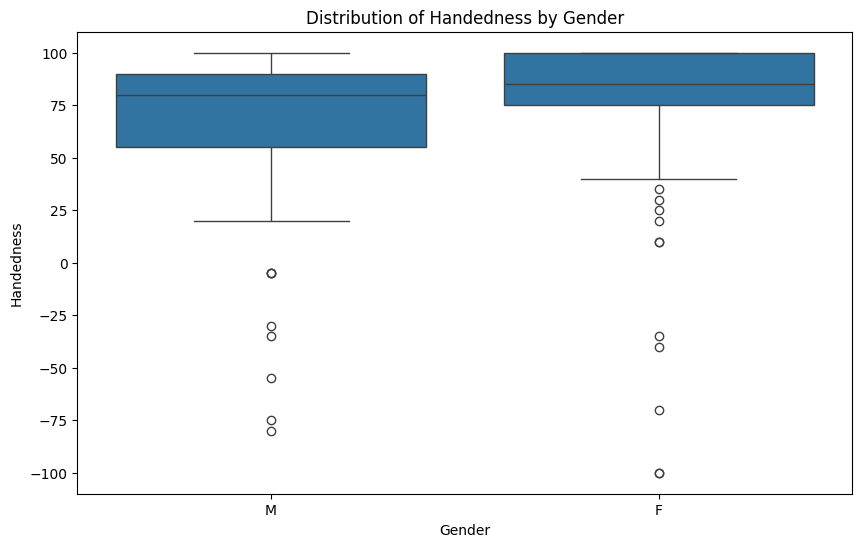

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=hand_data, x='Gender', y='Handedness')
plt.title("Distribution of Handedness by Gender")
plt.xlabel("Gender")
plt.ylabel("Handedness")
plt.show()

In [80]:
mmp_correlation_matrix_list = []
for i in range(mmp_data.shape[0]):
    person = mmp_data["Brain_Data"][i]
    #get matrix
    person_matrix = np.corrcoef(person.T)
    #append to list
    mmp_correlation_matrix_list.append(person_matrix)
#append to column
mmp_data["correlation_matrix"] = mmp_correlation_matrix_list

In [81]:
mmp_data.head()

Subject Release Acquisition Gender    Age  3T_Full_MR_Compl  T1_Count  \
0   100610    S900         Q08      M  26-30              True         2   
1   102311    S500         Q06      F  26-30              True         1   
2   102816      Q3         Q03      F  26-30              True         1   
3   104416    S900         Q09      F  31-35              True         2   
4   105923    MEG2         Q07      F  31-35              True         2   

   T2_Count  3T_RS-fMRI_Count  3T_RS-fMRI_PctCompl  ...  \
0         1                 4                100.0  ...   
1         1                 4                100.0  ...   
2         1                 4                100.0  ...   
3         2                 4                100.0  ...   
4         2                 4                100.0  ...   

   SSAGA_Times_Used_Opiates  SSAGA_Times_Used_Sedatives  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   

   SSAGA_Times_Used_Stimulants  SSAGA_Mj_Use  SSAGA_Mj_Ab_Dep  \
0                          0.0           0.0              0.0   
1                          0.0           0.0              0.0   
2                          0.0           1.0              0.0   
3                          0.0           1.0              0.0   
4                          0.0           1.0              0.0   

   SSAGA_Mj_Age_1st_Use  SSAGA_Mj_Times_Used  \
0                   NaN                  0.0   
1                   NaN                  0.0   
2                   2.0                  3.0   
3                   4.0                  3.0   
4                   4.0                  1.0   

                                          Brain_Data  Handedness_Cat  \
0  [[2.3968613, 0.33524948, -0.15465337, 1.955118...               1   
1  [[-0.13254918, 0.16243707, 0.300286, 0.6371644...               1   
2  [[0.19969857, -0.7308231, -0.46953073, 0.19398...               1   
3  [[-0.58722323, -2.054348, -2.3991566, -0.60077...               1   
4  [[0.4015313, -0.47590375, -0.058990948, -0.747...               1   

                                  correlation_matrix  
0  [[1.0, 0.46619928616491757, 0.5387587799680043...  
1  [[1.0, 0.4145113094959292, 0.342818966658749, ...  
2  [[0.9999999999999998, 0.2989986241314227, 0.52...  
3  [[0.9999999999999998, 0.5081583697070787, 0.59...  
4  [[1.0, 0.5963831451011642, 0.6588621195832001,...  

[5 rows x 785 columns]

In [78]:
mmp_regions = list(hcp.mmp.labels.values())
hcp.mmp.labels

{np.int64(0): np.str_(''),
 np.int64(1): np.str_('L_V1'),
 np.int64(2): np.str_('L_MST'),
 np.int64(3): np.str_('L_V6'),
 np.int64(4): np.str_('L_V2'),
 np.int64(5): np.str_('L_V3'),
 np.int64(6): np.str_('L_V4'),
 np.int64(7): np.str_('L_V8'),
 np.int64(8): np.str_('L_4'),
 np.int64(9): np.str_('L_3b'),
 np.int64(10): np.str_('L_FEF'),
 np.int64(11): np.str_('L_PEF'),
 np.int64(12): np.str_('L_55b'),
 np.int64(13): np.str_('L_V3A'),
 np.int64(14): np.str_('L_RSC'),
 np.int64(15): np.str_('L_POS2'),
 np.int64(16): np.str_('L_V7'),
 np.int64(17): np.str_('L_IPS1'),
 np.int64(18): np.str_('L_FFC'),
 np.int64(19): np.str_('L_V3B'),
 np.int64(20): np.str_('L_LO1'),
 np.int64(21): np.str_('L_LO2'),
 np.int64(22): np.str_('L_PIT'),
 np.int64(23): np.str_('L_MT'),
 np.int64(24): np.str_('L_A1'),
 np.int64(25): np.str_('L_PSL'),
 np.int64(26): np.str_('L_SFL'),
 np.int64(27): np.str_('L_PCV'),
 np.int64(28): np.str_('L_STV'),
 np.int64(29): np.str_('L_7Pm'),
 np.int64(30): np.str_('L_7m'),
 np

In [25]:
hcp.view_parcellation(hcp.mesh.inflated, hcp.mmp)

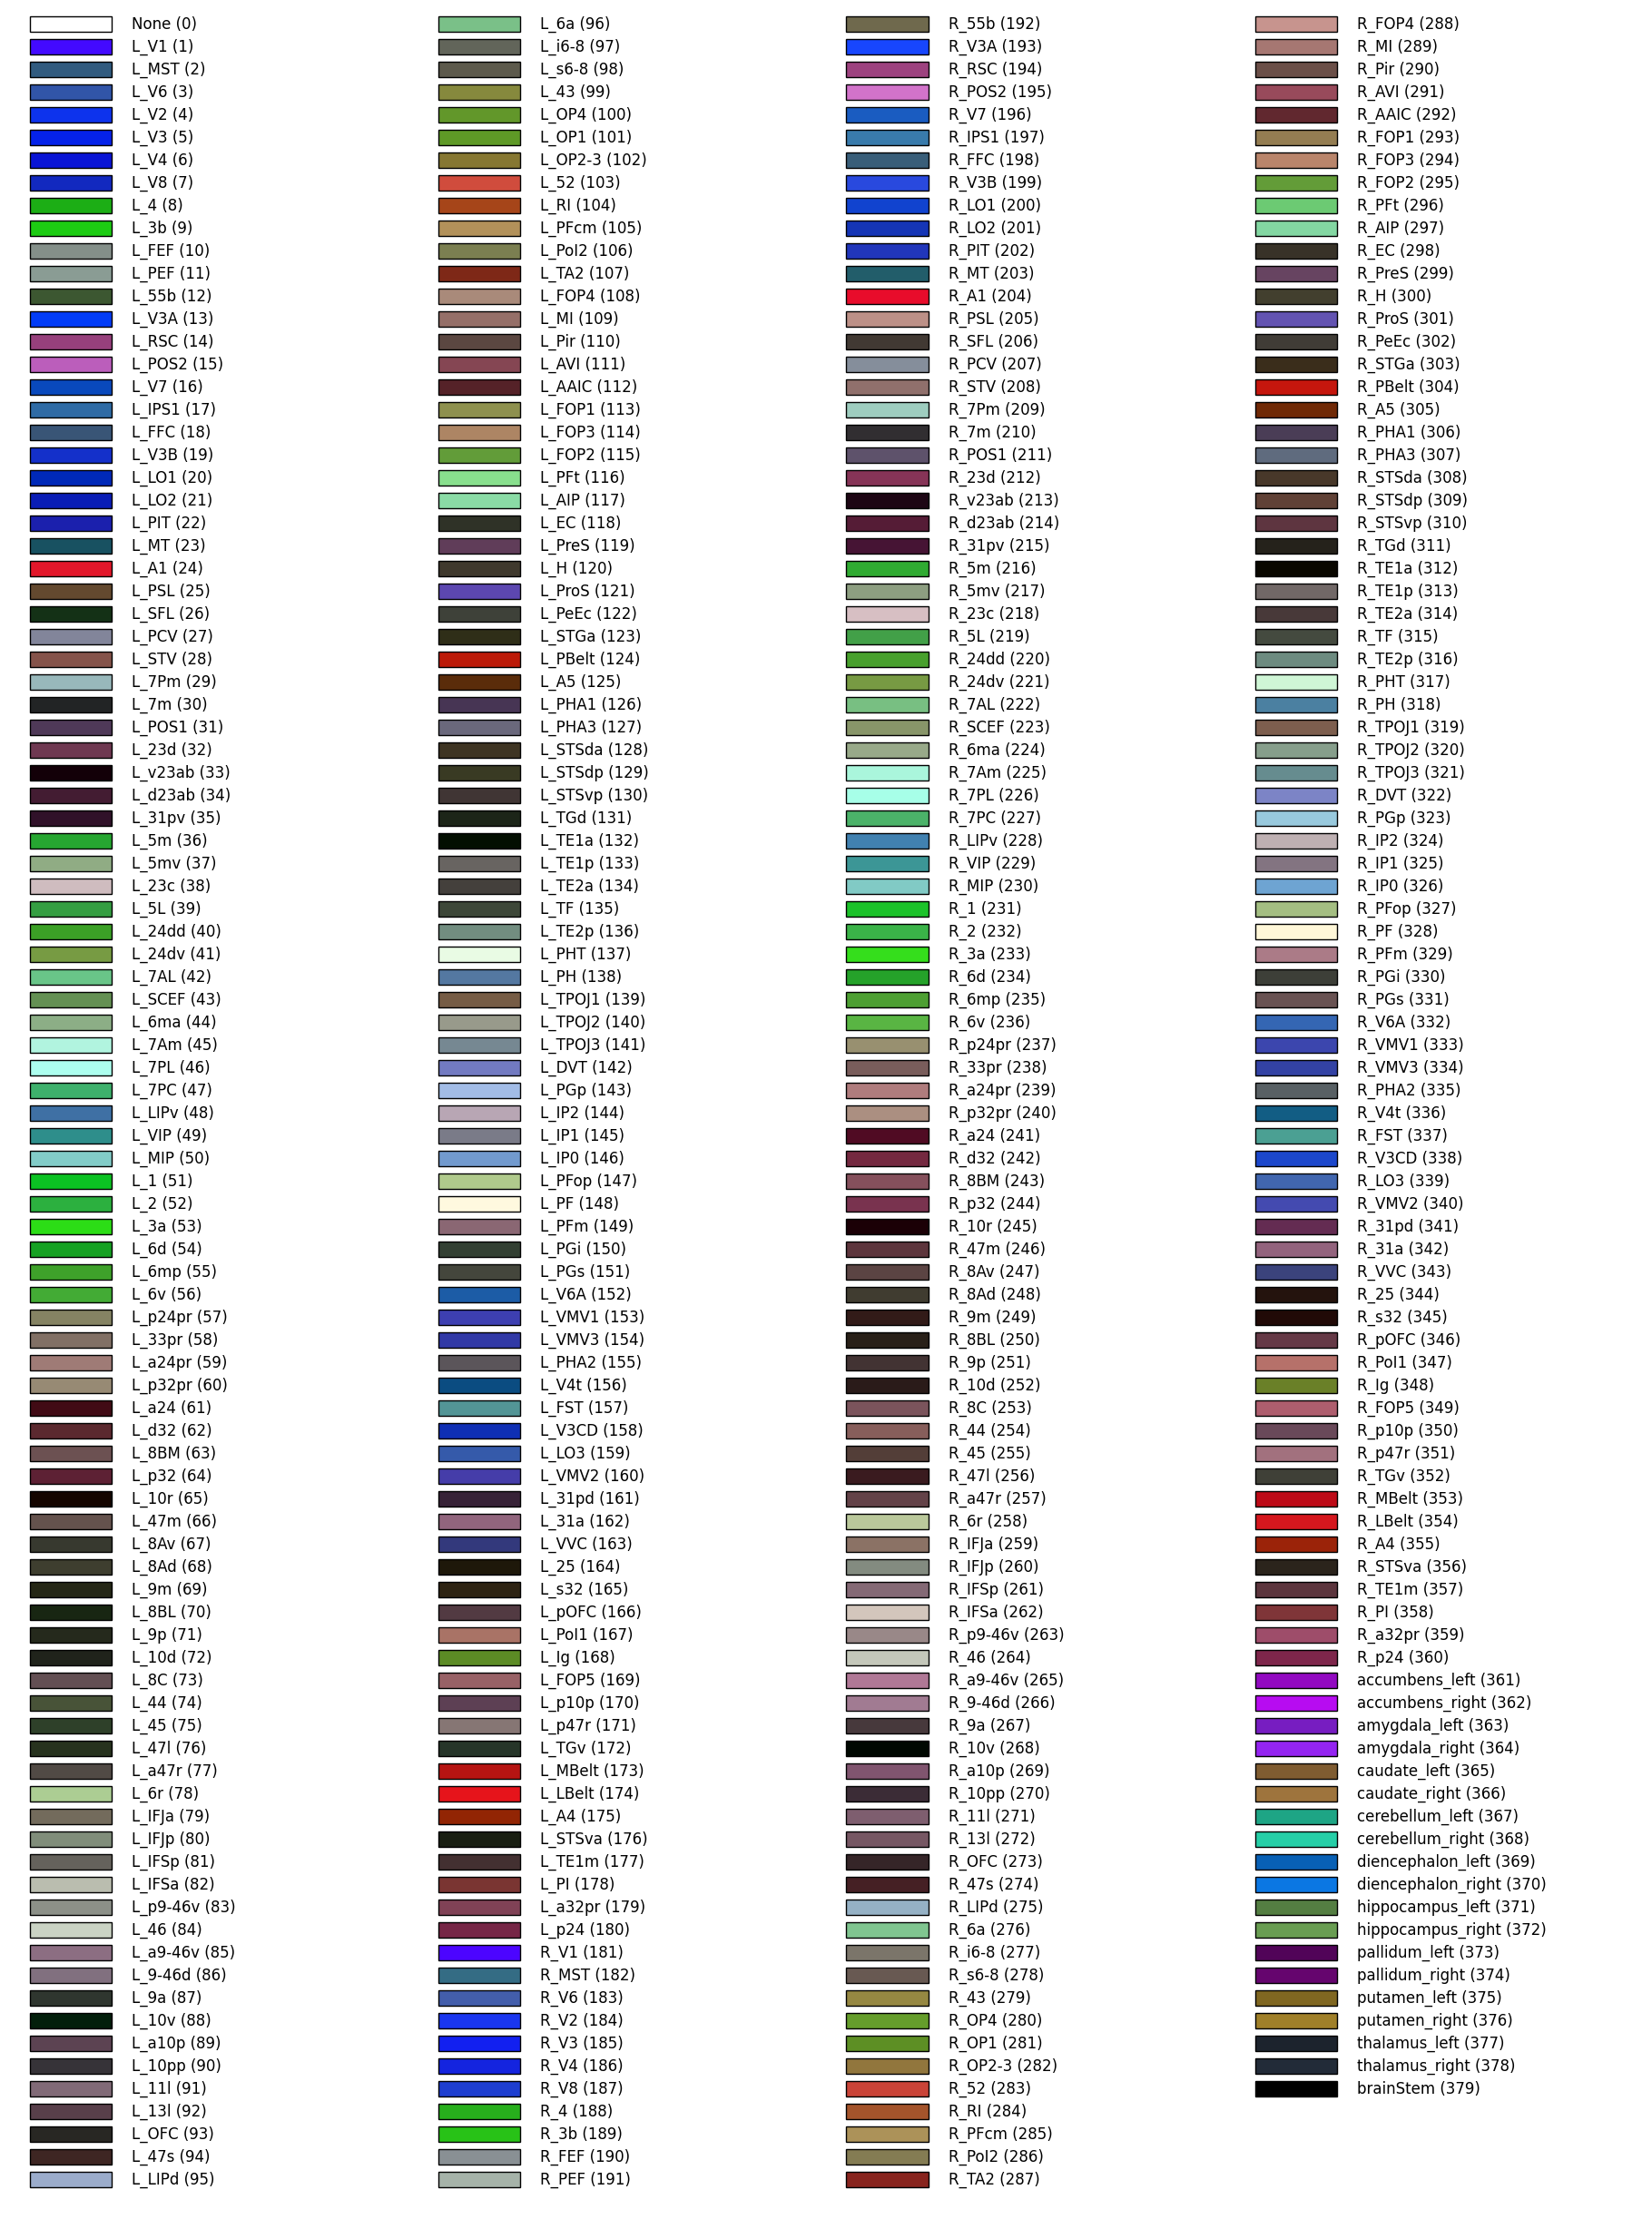

In [32]:
hcp.parcellation_labels(hcp.mmp)

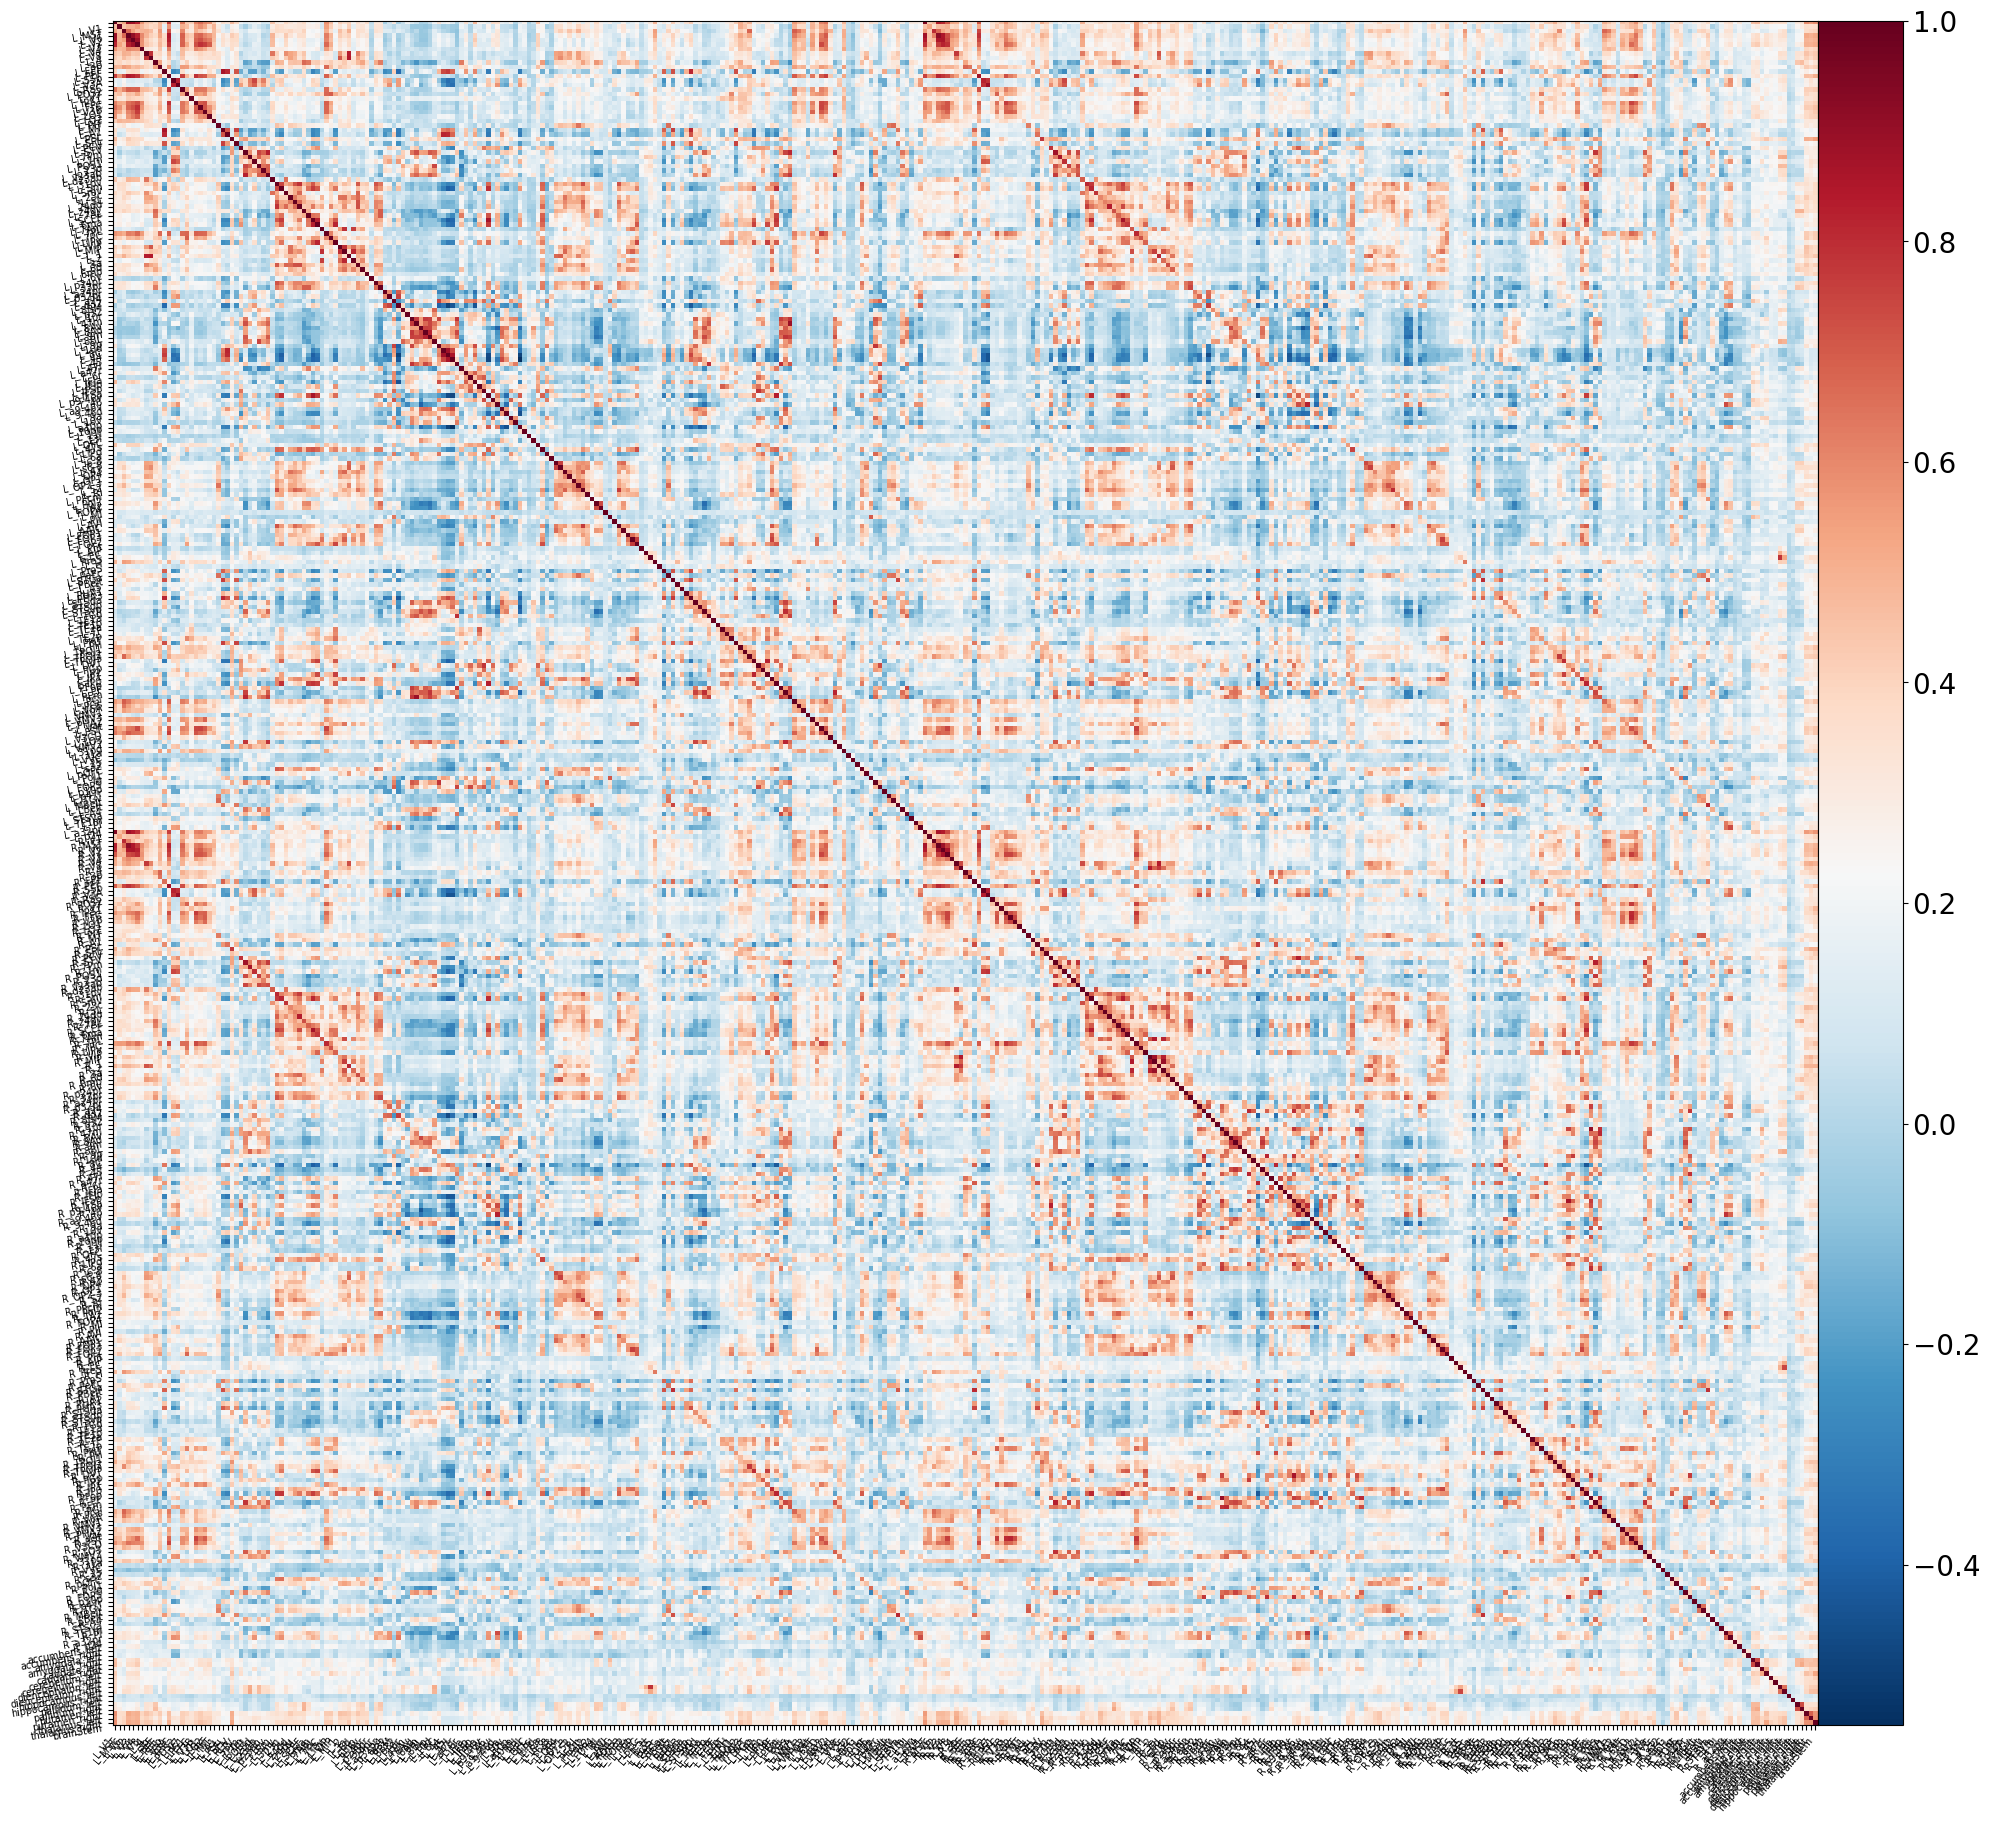

In [90]:
import matplotlib.pyplot as plt
import nilearn.plotting

fig = plt.figure(figsize=(20, 20))

display = nilearn.plotting.plot_matrix(
    mmp_correlation_matrix_list[0], 
    labels=mmp_regions[1:], 
    figure=fig
)


ax = plt.gca()


plt.xticks(rotation=90, fontsize=20) 
plt.yticks(fontsize=20)


plt.tight_layout()
plt.show()


In [208]:
handedness_regions = [
    # 1. Primary Motor & Somatosensory Cortex
    "L_4", "R_4",  # Primary Motor Cortex (M1)
    "L_1", "L_2", "L_3a", "R_1", "R_2", "R_3a",  # Somatosensory Cortex (S1)
    "L_3b", "R_3b",  # Secondary Somatosensory Cortex

    # 2. Premotor & Supplementary Motor Areas (SMA, PMd, PMv)
    "L_6mp", "R_6mp",  # Supplementary Motor Area (SMA)
    "L_6ma", "R_6ma",  # Medial Premotor Cortex
    "L_6d", "R_6d",  # Dorsal Premotor Cortex (PMd) - Reach, grasp control
    "L_6r", "R_6r",  # Rostral Premotor Cortex - Higher-order motor control
    "L_6a", "R_6a",  # Anterior Premotor Cortex
    "L_FEF", "R_FEF",  # Frontal Eye Fields (FEF) - Eye-hand coordination

    # 3. Parietal Cortex & Sensorimotor Integration
    "L_IPS1", "R_IPS1",  # Intraparietal Sulcus (IPS) - Sensorimotor integration
    "L_LIPv", "R_LIPv",
    "L_LIPd", "R_LIPd",
    "L_7AL", "R_7AL",  # Superior Parietal Lobule (SPL) - Hand coordination
    "L_7m", "R_7m",
    "L_7PC", "R_7PC",

    # 4. Corpus Callosum & Interhemispheric Connections
    "L_31pv", "R_31pv",
    "L_31pd", "R_31pd",
    "L_24dd", "R_24dd",  # Dorsal Anterior Cingulate Cortex - Motor learning
    "L_24dv", "R_24dv",  # Ventral Anterior Cingulate Cortex

    # 6. Prefrontal Cortex (Executive & Motor Control)
    "L_9-46d", "R_9-46d",  # Dorsolateral Prefrontal Cortex (DLPFC) - Movement decision-making
    "L_46", "R_46",
    "L_44", "R_44",  # Broca's area - Language-motor integration
    "L_45", "R_45",

    # 7. Additional Relevant Motor Control Regions
    "L_SCEF", "R_SCEF",  # Supplementary & Cingulate Eye Fields
    "L_MIP", "R_MIP",  # Medial Intraparietal - Reach planning
    "L_VIP", "R_VIP",  # Ventral Intraparietal - Visuomotor integration
    
    # 8. Subcortical Motor-related Areas
    "putamen_left", "putamen_right",
    "caudate_left", "caudate_right",
    "thalamus_left", "thalamus_right",
    "cerebellum_left", "cerebellum_right",

    # 9. Brainstem - Motor relay
    "brainStem"
]


In [231]:
mmp_regions = mmp_regions[1:]
mmp_regions

[np.str_('L_MST'),
 np.str_('L_V6'),
 np.str_('L_V2'),
 np.str_('L_V3'),
 np.str_('L_V4'),
 np.str_('L_V8'),
 np.str_('L_4'),
 np.str_('L_3b'),
 np.str_('L_FEF'),
 np.str_('L_PEF'),
 np.str_('L_55b'),
 np.str_('L_V3A'),
 np.str_('L_RSC'),
 np.str_('L_POS2'),
 np.str_('L_V7'),
 np.str_('L_IPS1'),
 np.str_('L_FFC'),
 np.str_('L_V3B'),
 np.str_('L_LO1'),
 np.str_('L_LO2'),
 np.str_('L_PIT'),
 np.str_('L_MT'),
 np.str_('L_A1'),
 np.str_('L_PSL'),
 np.str_('L_SFL'),
 np.str_('L_PCV'),
 np.str_('L_STV'),
 np.str_('L_7Pm'),
 np.str_('L_7m'),
 np.str_('L_POS1'),
 np.str_('L_23d'),
 np.str_('L_v23ab'),
 np.str_('L_d23ab'),
 np.str_('L_31pv'),
 np.str_('L_5m'),
 np.str_('L_5mv'),
 np.str_('L_23c'),
 np.str_('L_5L'),
 np.str_('L_24dd'),
 np.str_('L_24dv'),
 np.str_('L_7AL'),
 np.str_('L_SCEF'),
 np.str_('L_6ma'),
 np.str_('L_7Am'),
 np.str_('L_7PL'),
 np.str_('L_7PC'),
 np.str_('L_LIPv'),
 np.str_('L_VIP'),
 np.str_('L_MIP'),
 np.str_('L_1'),
 np.str_('L_2'),
 np.str_('L_3a'),
 np.str_('L_6d'),
 

In [232]:
def feature_row_get(target):
    target_index = mmp_regions.index(target)
    target_row = mmp_data['correlation_matrix'].apply(lambda x: x[target_index])
    
    return target_row


In [233]:
# Function to extract features automatically
def extract_features(region_list, data):
    """
    Extracts the correlation matrix rows for each brain region in region_list.
    
    Parameters:
    - region_list: List of brain region names (e.g., ["L_MT", "L_4", "R_4"])
    - data: DataFrame containing "correlation_matrix"
    
    Returns:
    - DataFrame with extracted features
    """
    # Copy the relevant columns first
    feature_data = data[["Handedness", "Handedness_Cat", "correlation_matrix"]].copy()

    # Compute the mean of the entire correlation matrix as a baseline feature
    feature_data["matrix_mean"] = data["correlation_matrix"].apply(lambda x: np.mean(x))

    # Apply feature_row_get() dynamically and store in a dictionary
    for region in region_list:
        feature_data[region] = feature_row_get(region)

    return feature_data


In [234]:
# Extract features for handedness prediction
feature_data = extract_features(handedness_regions, mmp_data)
feature_data

Handedness  Handedness_Cat  \
0            85               1   
1            10               1   
2           100               1   
3            65               1   
4            35               1   
..          ...             ...   
167          95               1   
168          85               1   
169          40               1   
170          80               1   
171         100               1   

                                    correlation_matrix  matrix_mean  \
0    [[1.0, 0.46619928616491757, 0.5387587799680043...     0.175993   
1    [[1.0, 0.4145113094959292, 0.342818966658749, ...     0.186351   
2    [[0.9999999999999998, 0.2989986241314227, 0.52...     0.258471   
3    [[0.9999999999999998, 0.5081583697070787, 0.59...     0.211318   
4    [[1.0, 0.5963831451011642, 0.6588621195832001,...     0.327927   
..                                                 ...          ...   
167  [[1.0, 0.5868952668034533, 0.6650024441927097,...     0.368026   
168  [[1.0, 0.2527353927273103, 0.6220543671787876,...     0.230883   
169  [[1.0, 0.4077766140820082, 0.5679625164532214,...     0.466140   
170  [[0.9999999999999998, 0.4373132861456234, 0.65...     0.312844   
171  [[1.0, 0.1745251119720137, 0.5239475526043362,...     0.213796   

                                                   L_4  \
0    [0.5655042489288084, 0.47215736350078624, 0.48...   
1    [0.27950324388674347, 0.5160751689901244, 0.60...   
2    [0.5665464168753875, 0.43958903526489707, 0.52...   
3    [0.5243422360920559, 0.5631150332150615, 0.473...   
4    [0.7768947695596158, 0.6719296347335755, 0.614...   
..                                                 ...   
167  [0.5776770567314055, 0.6050715851307583, 0.615...   
168  [0.426400748503486, 0.3600449730537894, 0.3471...   
169  [0.525029466699364, 0.7902714102225853, 0.7699...   
170  [0.6133016535453031, 0.4945503307059637, 0.582...   
171  [0.36242905804814, 0.4506327199781906, 0.42305...   

                                                   R_4  \
0    [0.5267586333106062, 0.3762535955804584, 0.549...   
1    [0.47003806788982255, 0.7122207121705463, 0.68...   
2    [0.5442472068571362, 0.5203863733522214, 0.646...   
3    [0.49435697597234973, 0.5909274514858922, 0.53...   
4    [0.6923119183436668, 0.6870371993644093, 0.636...   
..                                                 ...   
167  [0.6761546948908463, 0.6608578823820772, 0.643...   
168  [0.4972385973704748, 0.339942001716099, 0.5440...   
169  [0.6749980813263607, 0.7578474617125356, 0.746...   
170  [0.6669940467858589, 0.5577777429504324, 0.534...   
171  [0.3465490723973617, 0.35449877442447647, 0.40...   

                                                   L_1  \
0    [0.2285093414459767, 0.26436784152715714, 0.16...   
1    [0.2155730749713044, 0.387012289745582, 0.5024...   
2    [0.44412259666086007, 0.2774200406728021, 0.40...   
3    [0.35032278583160764, 0.4142589340788214, 0.38...   
4    [0.46769668896788835, 0.45021718643298325, 0.4...   
..                                                 ...   
167  [0.5006901121753013, 0.46691903644016947, 0.32...   
168  [0.17185481562728147, 0.3870921077777404, 0.27...   
169  [0.4910413857856399, 0.6914965101483621, 0.626...   
170  [0.38800667966822877, 0.2553311093692986, 0.36...   
171  [0.257154959115011, 0.5260376807596321, 0.3077...   

                                                   L_2  \
0    [0.40548299302723256, 0.3255226507827946, 0.46...   
1    [0.1866388091202092, 0.5719445130192548, 0.707...   
2    [0.30591984028492586, 0.3901975349387497, 0.58...   
3    [0.3937560464391664, 0.5432009909529222, 0.607...   
4    [0.45131751729769015, 0.6203443289412882, 0.62...   
..                                                 ...   
167  [0.3814659886450934, 0.48637599747041455, 0.49...   
168  [0.46356821240382845, 0.3616333209016325, 0.47...   
169  [0.33420252438111026, 0.7537192574490216, 0.64...   
170  [0.46300169231733235, 0.40169308968474127, 0.5...   
17

In [242]:
def flatten_features(row, region_list):
    """
    Flattens selected brain region features into a single numpy array.
    
    Parameters:
    - row: A single row from the DataFrame
    - region_list: List of selected brain regions
    
    Returns:
    - 1D numpy array containing all extracted feature values
    """
    # Flatten the correlation matrix (if applicable)
    corr_mat = np.array(row["correlation_matrix"]).flatten()

    # Extract all relevant region values dynamically
    region_values = [np.array(row[region]) for region in region_list if region in row]

    # Concatenate into one feature array
    return np.concatenate(region_values)


In [243]:
feature_data_all = feature_data.copy()

In [244]:
filtered_df = feature_data[(feature_data['Handedness'] > 25) | (feature_data['Handedness'] < -25)]

# # Separate into left and right handed
# left_handed = filtered_df[filtered_df['Handedness'] < 0]
# right_handed = filtered_df[filtered_df['Handedness'] > 0]

# # Determine the number of samples to select from the right-handed data
# num_samples = min(len(left_handed), len(right_handed))

# # Randomly sample from the right-handed data
# right_handed_sample = right_handed.sample(n=num_samples, random_state=42)

# # Combine the left and right handed data
# df = pd.concat([left_handed, right_handed_sample])

# # Optionally shuffle the final dataframe to mix left and right handed samples
# df = df.sample(frac=1).reset_index(drop=True)

feature_data = filtered_df


In [245]:
feature_data.shape

(164, 69)

In [247]:
test_result = []
trial_ci = []
trial_acc = []

for i in range(20):
    
    # Now apply this function to each row in the DataFrame to create your X matrix:
    X_list = feature_data.apply(lambda row: flatten_features(row, handedness_regions), axis=1)
    # X_list will be a column of arrays. Convert to a 2D array:
    X = np.vstack(X_list.values)


    # y is simply the "Handedness" column:
    y = feature_data["Handedness_Cat"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        # random_state=42, 
        test_size=0.3,
        stratify=y
    )
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import math

test_result = []
trial_ci = []
trial_acc = []

for i in range(20):
    
    
    X_list = feature_data.apply(lambda row: flatten_features(row, handedness_regions), axis=1)
    X = np.vstack(X_list.values)  # Convert to a 2D NumPy array
    y = feature_data["Handedness_Cat"]

    # feature selection w/ Lasso
    lasso = LassoCV(cv=5).fit(X, y)
    sfm = SelectFromModel(lasso, prefit=True)
    X_selected = sfm.transform(X)  # 仅保留重要特征

    print("Number of selected features:", X_selected.shape[1])

    # train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.5, stratify=y, random_state=42
    )

    # SMOTE for training set
    smote = SMOTE(k_neighbors=2, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # print("Before SMOTE:", Counter(y_train)) 
    # print("After SMOTE:", Counter(y_train_resampled)) 

    # train SVM model
    model_class = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", probability=True, C=1.0))
    ])
    model_class.fit(X_train_resampled, y_train_resampled)
    y_pred = model_class.predict(X_test)

    # Balanced Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred) 
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Run {i+1}:")
    print("Accuracy of SVM Model:", accuracy)
    print("Balanced Accuracy:", balanced_acc)
    print("Confusion Matrix:\n", conf_matrix)

    # 95% CI
    n_test = len(y_test)
    z_value = 1.96  # for ~95% CI
    std_error = math.sqrt(accuracy * (1 - accuracy) / n_test)

    ci_lower = accuracy - z_value * std_error
    ci_upper = accuracy + z_value * std_error

    print(f"95% CI for Accuracy: [{ci_lower:.4f}, {ci_upper:.4f}]")

    trial_ci.append([ci_lower, ci_upper])
    trial_acc.append(accuracy)
    test_result.append(accuracy)

print(f"Final Average Accuracy: {np.mean(test_result):.4f}")
print(f"Final Average Balanced Accuracy: {np.mean(balanced_acc):.4f}")

np.mean(test_result)

Number of selected features: 10
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Run 1:
Accuracy of SVM Model: 0.9512195121951219
Balanced Accuracy: 0.6935064935064935
Confusion Matrix:
 [[ 2  3]
 [ 1 76]]
95% CI for Accuracy: [0.9046, 0.9978]
Number of selected features: 10
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Run 2:
Accuracy of SVM Model: 0.9512195121951219
Balanced Accuracy: 0.6935064935064935
Confusion Matrix:
 [[ 2  3]
 [ 1 76]]
95% CI for Accuracy: [0.9046, 0.9978]
Number of selected features: 10
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Run 3:
Accuracy of SVM Model: 0.9512195121951219
Balanced Accuracy: 0.6935064935064935
Confusion Matrix:
 [[ 2  3]
 [ 1 76]]
95% CI for Accuracy: [0.9046, 0.9978]
Number of selected features: 10
Before SMOTE: Counter({1: 77, 0: 5})
After SMOTE: Counter({1: 77, 0: 77})
Run 4:
Accuracy of SVM Model: 0.9512195121951219
Balanced Accuracy: 0.6935064935064935


np.float64(0.9512195121951222)

In [166]:
y_test, y_pred

(136    1
 106    1
 99     1
 13     0
 117    1
       ..
 76     1
 84     1
 43     1
 71     0
 33     1
 Name: Handedness_Cat, Length: 82, dtype: int64,
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [147]:
y.value_counts()

Handedness_Cat
1    10
0    10
Name: count, dtype: int64

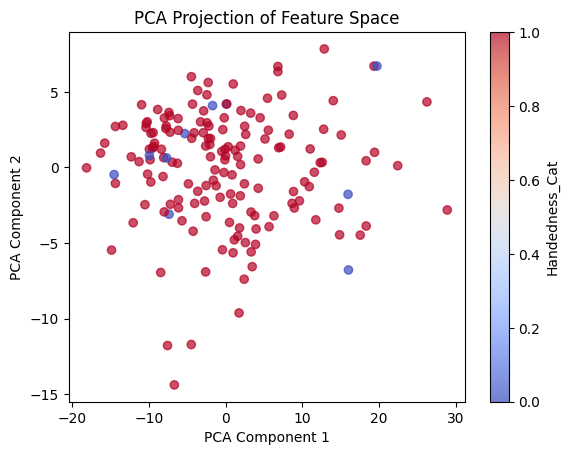

In [177]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Feature Space")
plt.colorbar(label="Handedness_Cat")
plt.show()


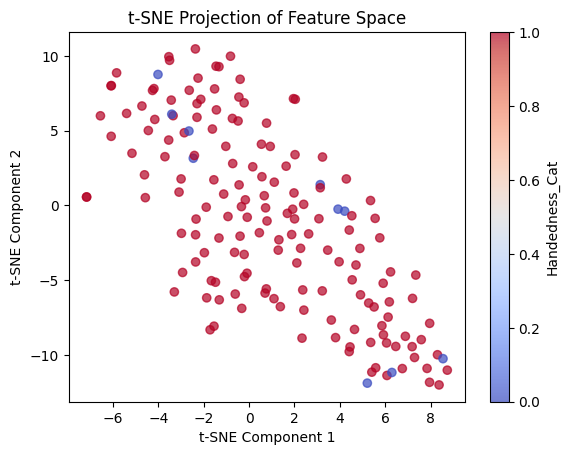

In [178]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of Feature Space")
plt.colorbar(label="Handedness_Cat")
plt.show()


### CNN

In [107]:
feature_data_all = feature_data_all[(feature_data_all['Handedness'] > 25) | (feature_data_all['Handedness'] < -25)]


In [188]:
# ------------------------------------------------------------------------------
# 1. Custom feature function that:
#    - Keeps correlation_matrix as a 2D array (N x N)
#    - Leaves all the other "semi_*" arrays as 1D
#    - Returns them separately so we can feed them into a multi-input (or single-input) model.
# ------------------------------------------------------------------------------
def extract_features_2d(row):
    """
    Extract the correlation matrix as 2D,
    and keep other features separate in 1D form.
    """
    # The correlation matrix as an N x N 2D array:
    corr_mat_2d = np.array(row["correlation_matrix"])
    semi_MTG = np.array(row["semi_MTG"])

    semi_ACC_1 = np.array(row["semi_ACC_1"])
    semi_ACC_2 = np.array(row["semi_ACC_2"])
    semi_ACC_3 = np.array(row["semi_ACC_3"])
    semi_ACC_4 = np.array(row["semi_ACC_4"])
    semi_ACC_5 = np.array(row["semi_ACC_5"])
    semi_ACC_6 = np.array(row["semi_ACC_6"])
    semi_ACC_7 = np.array(row["semi_ACC_7"])
    semi_ACC_8 = np.array(row["semi_ACC_8"])
    semi_ACC_9 = np.array(row["semi_ACC_9"])
    semi_ACC_10 = np.array(row["semi_ACC_10"])

    semi_MCC_1 = np.array(row["semi_MCC_1"])
    semi_MCC_2 = np.array(row["semi_MCC_2"])
    semi_MCC_3 = np.array(row["semi_MCC_3"])
    semi_MCC_4 = np.array(row["semi_MCC_4"])


    semi_ANG_1 = np.array(row["semi_ANG_1"])
    semi_ANG_2 = np.array(row["semi_ANG_2"])
    semi_ANG_3 = np.array(row["semi_ANG_3"])

    semi_AMYG = np.array(row["semi_AMYG"])
    

    new_1 = np.array(row["new_1"])
    new_2 = np.array(row["new_2"])
    new_3 = np.array(row["new_3"])
    new_4 = np.array(row["new_4"])
    new_5 = np.array(row["new_5"])
    new_6 = np.array(row["new_6"])
    new_7 = np.array(row["new_7"])
    new_8 = np.array(row["new_8"])
    new_9 = np.array(row["new_9"])
    new_10 = np.array(row["new_10"])
    new_11 = np.array(row["new_11"])
    new_12 = np.array(row["new_12"])
    new_13 = np.array(row["new_13"])
    new_14 = np.array(row["new_14"])
    new_15 = np.array(row["new_15"])
    new_16 = np.array(row["new_16"])
    new_17 = np.array(row["new_17"])
    new_18 = np.array(row["new_18"])
    new_19 = np.array(row["new_19"])


    # Concatenate the 1D arrays into one big 1D vector:
    other_1d_feats = np.concatenate([
        semi_MTG, 

        semi_ACC_1,
        semi_ACC_2,
        semi_ACC_3,
        semi_ACC_4,
        semi_ACC_5,
        semi_ACC_6,
        semi_ACC_7,
        semi_ACC_8,
        semi_ACC_9,
        semi_ACC_10,

        semi_MCC_1,
        semi_MCC_2,
        semi_MCC_3,
        semi_MCC_4,

        semi_ANG_1, 
        semi_ANG_2, 
        semi_ANG_3, 
        semi_AMYG, 
        
        new_1, 
        new_2, 
        new_3, 
        new_4, 
        new_5, 
        new_6,
        new_7,
        new_8,
        new_9,
        new_10,
        new_11,
        new_12,
        new_13,
        new_14,
        new_15,
        new_16,
        new_17,
        new_18,
        new_19
    ])

    return corr_mat_2d, other_1d_feats

# ------------------------------------------------------------------------------
# 2. Apply this function to each row of your DataFrame
#    to build two separate lists: one for the 2D matrices, one for the 1D features.
# ------------------------------------------------------------------------------
corr_list = []
other_list = []

for idx, row in feature_data_all.iterrows():
    mat2d, vec1d = extract_features_2d(row)
    corr_list.append(mat2d)
    other_list.append(vec1d)

# Convert them to numpy arrays
X_corr = np.array(corr_list)   # shape: (n_samples, N, N)
X_other = np.array(other_list) # shape: (n_samples, #features)

# For Keras Conv2D, you typically need a 4D tensor: (batch_size, height, width, channels)
# So add a channel dimension:
# Suppose X_corr is shape (n_samples, 379, 379, 1), but might be string-dtype
X_corr = X_corr.astype("float32")

# Suppose X_other is shape (n_samples, 14402), might be string-dtype
X_other = X_other.astype("float32")

label_encoder = LabelEncoder()
y = feature_data_all["Handedness_Cat"]
y_numeric = label_encoder.fit_transform(y)  # e.g., 0/1

X_corr_train, X_corr_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_corr, X_other, y_numeric, test_size=0.25
)

# First, flatten the image (correlation matrix) data.
n_train = X_corr_train.shape[0]
h, w, c = X_corr_train.shape[1], X_corr_train.shape[2], 1
X_corr_train_flat = X_corr_train.reshape(n_train, -1)  # shape: (n_train, h*w)

# Now, horizontally stack with the other features.
X_train_combined = np.hstack([X_corr_train_flat, X_other_train])  # shape: (n_train, h*w + n_other_features)

# Apply oversampling using RandomOverSampler.
ros = RandomOverSampler()
X_train_resampled_combined, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

# Split the resampled data back into the two inputs.
num_corr_features = h * w  # number of columns corresponding to X_corr
X_corr_train_resampled_flat = X_train_resampled_combined[:, :num_corr_features]
X_other_train_resampled = X_train_resampled_combined[:, num_corr_features:]

# Reshape the flattened correlation features back into their original 4D shape.
X_corr_train_resampled = X_corr_train_resampled_flat.reshape(-1, h, w, c)


# Build your model
input_corr = tf.keras.layers.Input(shape=(379, 379, 1), name="corr_input")
x1 = tf.keras.layers.Conv2D(8, (2,2), activation='relu')(input_corr)
x1 = tf.keras.layers.Flatten()(x1)

input_other = tf.keras.layers.Input(shape=(14402,), name="other_input")
x2 = tf.keras.layers.Dense(16, activation='relu')(input_other)

merged = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.Dense(16, activation='relu')(merged)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=[input_corr, input_other], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Fit
model.fit(
    [X_corr_train_resampled, X_other_train_resampled],
    y_train_resampled,
    validation_data=([X_corr_test, X_other_test], y_test),
    epochs=5,
    batch_size=8
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ corr_input          │ (None, 379, 379,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 378, 378,  │         40 │ corr_input[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 14402)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1143072)   │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │    230,448 │ other_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 1143088)   │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 16)        │ 18,289,424 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         17 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,519,929 (70.65 MB)

 Trainable params: 18,519,929 (70.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5484 - loss: 9.6294 - val_accuracy: 0.9535 - val_loss: 0.4552
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9810 - loss: 0.0502 - val_accuracy: 0.9535 - val_loss: 0.9466
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9178 - loss: 0.5426 - val_accuracy: 0.9535 - val_loss: 1.1092
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9833 - loss: 0.0766 - val_accuracy: 0.9535 - val_loss: 1.0891
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 1.0000 - loss: 1.7692e-04 - val_accuracy: 0.9535 - val_loss: 0.9176


In [189]:
loss, mae = model.evaluate([X_corr_test, X_other_test], y_test, verbose=0)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)

# 2. Generate predictions on the test set.
y_pred = model.predict([X_corr_test, X_other_test])

Test Loss (MSE): 0.9175878763198853
Test MAE: 0.9534883499145508
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 


In [190]:
y_pred

array([[1.        ],
       [1.        ],
       [1.        ],
       [0.99917805],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999945 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)